# Cab Fare Prediction

The objective of this project is to predict Cab Fare amount. 

## Stage 1: Importing dependencies

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.metrics import r2_score
from fancyimpute import KNN
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import xgboost as xgb
import datetime
import math
%matplotlib inline

## Stage 2: Data Preprocessing

### Loading files

Obviously, the first step is to load our files.

In [3]:
cab_df = pd.read_csv('train_cab.csv')

In [4]:
cab_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [5]:
cab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16043 non-null object
pickup_datetime      16067 non-null object
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: float64(5), object(2)
memory usage: 878.8+ KB


#### The details of data attributes in the dataset are as follows:
- pickup_datetime - timestamp value indicating when the cab ride started.
- pickup_longitude - float for longitude coordinate of where the cab ride started.
- pickup_latitude - float for latitude coordinate of where the cab ride started.
- dropoff_longitude - float for longitude coordinate of where the cab ride ended.
- dropoff_latitude - float for latitude coordinate of where the cab ride ended.
- passenger_count - an integer indicating the number of passengers in the cab ride.

Data Type conversion : So that pickup_datetime and fare_amount get converted to proper datatypes.

In [6]:
#convert date columns from object to datetime
cab_df['pickup_datetime'] = pd.to_datetime(cab_df['pickup_datetime'],errors='coerce')
#convert fare_amount column from object to numeric
cab_df['fare_amount'] = pd.to_numeric(cab_df['fare_amount'],errors='coerce')

In [7]:
cab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16042 non-null float64
pickup_datetime      16066 non-null datetime64[ns, UTC]
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 878.8 KB


In [8]:
cab_df.shape

(16067, 7)

### Missing Value Exploration

In [9]:
cab_df.isna().sum()

fare_amount          25
pickup_datetime       1
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
dtype: int64

In [10]:
cab_df[(cab_df['pickup_datetime'].isna()==True)]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
1327,11.5,NaT,-73.981947,40.7282,-73.988582,40.759202,1.0


In [11]:
#As there is only 1 inappropriate format of datetime so deleting it
cab_df = cab_df[cab_df.pickup_datetime.notnull()] 

In [12]:
cab_df.shape

(16066, 7)

In [13]:
missing_val = pd.DataFrame(cab_df.isnull().sum().sort_values(ascending = False)).reset_index()
missing_val = missing_val.rename(columns={'index':'variables',0:'missing_percentage'}).reset_index(drop=True)
missing_val['missing_percentage']=(missing_val['missing_percentage']/len(cab_df))*100
missing_val=missing_val.sort_values(by='missing_percentage',ascending=False).reset_index(drop=True)
missing_val

,variables,missing_percentage
0,passenger_count,0.342338
1,fare_amount,0.155608
2,dropoff_latitude,0.000000
3,dropoff_longitude,0.000000
4,pickup_latitude,0.000000
5,pickup_longitude,0.000000
6,pickup_datetime,0.000000


In [14]:
cab_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16041.000000,16066.000000,16066.000000,16066.000000,16066.000000,16011.000000
mean,15.015223,-72.462693,39.914675,-72.462233,39.897852,2.625171
std,430.474362,10.578707,6.826797,10.575384,6.187276,60.846021
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992156,40.734935,-73.991182,40.734647,1.000000
50%,8.500000,-73.981697,40.752605,-73.980170,40.753566,1.000000
75%,12.500000,-73.966837,40.767381,-73.963642,40.768015,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


In [15]:
#Converting pickup_datetime back to numeric as for knn imputation all variables must be of numeric type
cab_df['pickup_datetime']=pd.to_numeric(cab_df['pickup_datetime'])

In [16]:
#As median gives the closest value so we fill all missing values with median
cab_df['fare_amount']= cab_df['fare_amount'].fillna(cab_df['fare_amount'].median())

In [17]:
cab_df['passenger_count']= cab_df['passenger_count'].fillna(cab_df['passenger_count'].mean())

In [18]:
cab_df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [19]:
#Converting datetime back to its original datatype
cab_df['pickup_datetime']=pd.to_datetime(pd.to_numeric( pd.to_datetime( cab_df['pickup_datetime'], origin = '1970-01-01' ) ), 
                                     origin = '1970-01-01')

## Exploratory Data Analysis

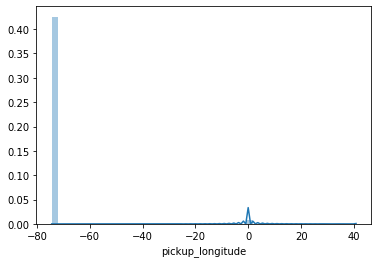

In [20]:
sns.distplot(cab_df['pickup_longitude'],kde=True)

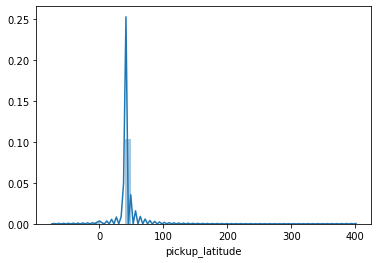

In [21]:
sns.distplot(cab_df['pickup_latitude'],kde=True)

In [22]:
coutliers = ['fare_amount', 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'passenger_count']

In [23]:
cab_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16066.000000,16066.000000,16066.000000,16066.000000,16066.000000,16066.000000
mean,15.005085,-72.462693,39.914675,-72.462233,39.897852,2.625171
std,430.139361,10.578707,6.826797,10.575384,6.187276,60.741775
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992156,40.734935,-73.991182,40.734647,1.000000
50%,8.500000,-73.981697,40.752605,-73.980170,40.753566,1.000000
75%,12.500000,-73.966837,40.767381,-73.963642,40.768015,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


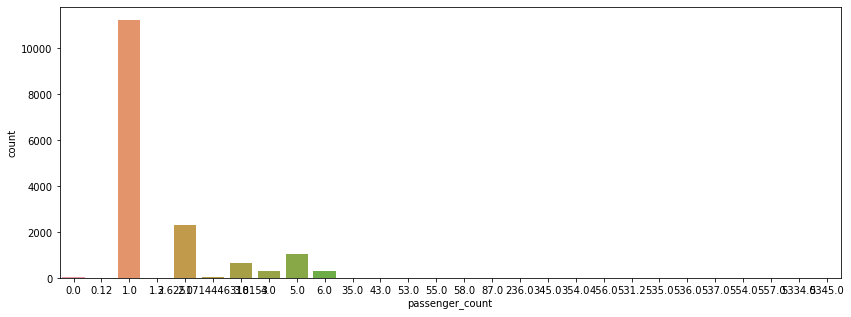

In [24]:

# plot of the passenger_count
plt.figure(figsize=(14,5))
sns.countplot(x='passenger_count', data=cab_df)

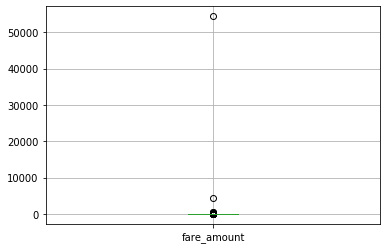

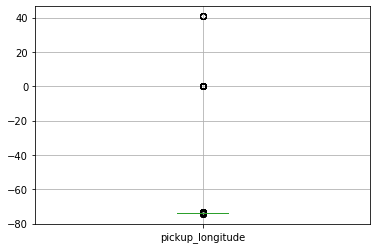

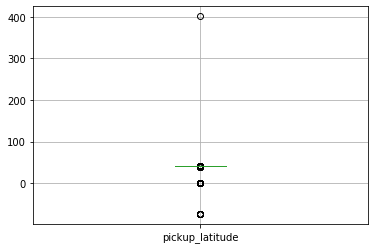

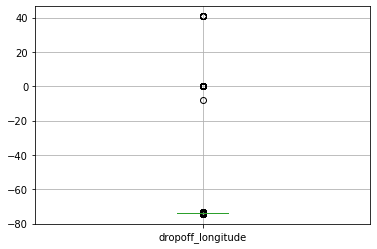

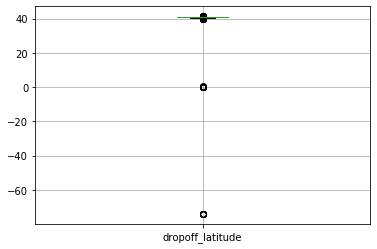

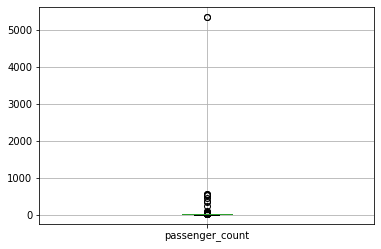

In [25]:
for i in coutliers:
    cab_df.boxplot(column=i)
    plt.show()

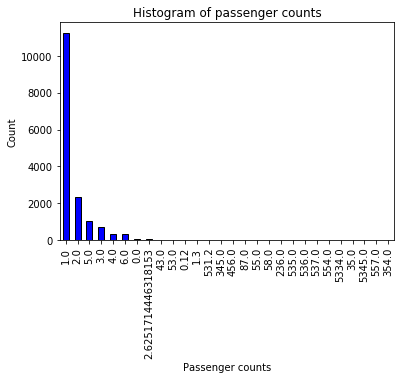

In [26]:
cab_df['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Histogram of passenger counts'); 
plt.xlabel('Passenger counts'); 
plt.ylabel('Count');

### Distribution of Trip Fare

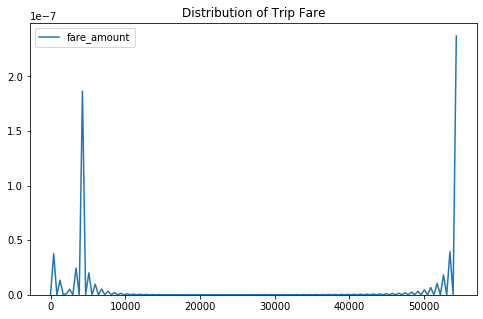

In [27]:
plt.figure(figsize=(8,5))
ax = sns.kdeplot(cab_df['fare_amount']).set_title("Distribution of Trip Fare")

There are some negative fare amount in the data and also it is skewed. Let us have a look at these data points

There are only 3 records with negative fare. We will remove these records from the data

Since we saw above that fare amount is highly skewed,let us take log transformation of the fare amount and plot the distribution

Text(0.5, 1.0, 'Distribution of fare amount (log scale)')

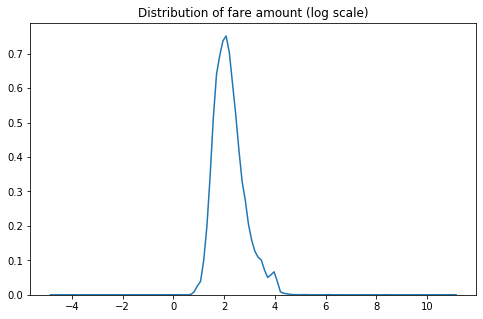

In [28]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(cab_df['fare_amount'].values)).set_title("Distribution of fare amount (log scale)")

(6.0, 0.0)

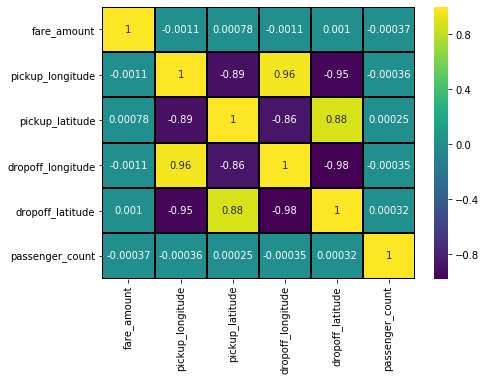

In [29]:
f, ax=plt.subplots(figsize=(7,5))

sns.heatmap(cab_df.corr(), mask=np.zeros_like(cab_df.corr(), dtype=np.bool), cmap='viridis',linewidths=1,linecolor='black',annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [30]:
#Detect and delete outliers from data
for i in coutliers:
    print(i)
    q75, q25 = np.percentile(cab_df.loc[:,i], [75 ,25])
    iqr = q75 - q25

    min = q25 - (iqr*1.5)
    max = q75 + (iqr*1.5)
    print(min)
    print(max)
    #cab_df.loc[cab_df[i] < min,i] = np.nan
    #cab_df.loc[cab_df[i] > max,i] = np.nan
    cab_df=cab_df.drop(cab_df[cab_df.loc[:,i]<min].index)
    cab_df=cab_df.drop(cab_df[cab_df.loc[:,i]>max].index)

fare_amount
-3.75
22.25
pickup_longitude
-74.02812166000001
-73.9329439
pickup_latitude
40.69341799999999
40.81095600000001
dropoff_longitude
-74.0258265
-73.93522250000001
dropoff_latitude
40.69407100000001
40.811451000000005
passenger_count
-0.5
3.5


In [31]:
cab_df = cab_df[(cab_df['passenger_count']>= 1)]
cab_df = cab_df[(cab_df['fare_amount']>=1)]
cab_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,11824.000000,11824.000000,11824.000000,11824.000000,11824.000000,11824.000000
mean,8.563490,-73.981886,40.752954,-73.981039,40.753368,1.260794
std,3.816782,0.016014,0.021029,0.016500,0.021894,0.539658
min,2.500000,-74.018108,40.693504,-74.019535,40.694260,1.000000
25%,5.700000,-73.992841,40.738610,-73.992088,40.738855,1.000000
50%,7.700000,-73.982749,40.753510,-73.982093,40.754582,1.000000
75%,10.500000,-73.971549,40.766776,-73.970891,40.767358,1.000000
max,22.100000,-73.932999,40.810862,-73.935237,40.811445,3.000000


# Feature Engineering

In [32]:
### we will saperate the Pickup_datetime column into separate field like year, month, day of the week, etc

cab_df['year'] = cab_df.pickup_datetime.dt.year
cab_df['month'] = cab_df.pickup_datetime.dt.month
cab_df['day'] = cab_df.pickup_datetime.dt.day
cab_df['weekday'] = cab_df.pickup_datetime.dt.weekday
cab_df['hour'] = cab_df.pickup_datetime.dt.hour

In [33]:
cab_df.info()
#cab_df = cab_df.drop(cab_df['pickup_datetime'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11824 entries, 1 to 16066
Data columns (total 12 columns):
fare_amount          11824 non-null float64
pickup_datetime      11824 non-null datetime64[ns]
pickup_longitude     11824 non-null float64
pickup_latitude      11824 non-null float64
dropoff_longitude    11824 non-null float64
dropoff_latitude     11824 non-null float64
passenger_count      11824 non-null float64
year                 11824 non-null int64
month                11824 non-null int64
day                  11824 non-null int64
weekday              11824 non-null int64
hour                 11824 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(5)
memory usage: 1.2 MB


In [34]:
del cab_df['pickup_datetime']

Calculating the distance between given coordinates.

In [35]:
#haversine function

def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
   
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [36]:
cab_df['distance'] = \
    haversine( cab_df['pickup_latitude'], cab_df['pickup_longitude'],
                cab_df['dropoff_latitude'], cab_df['dropoff_longitude'])

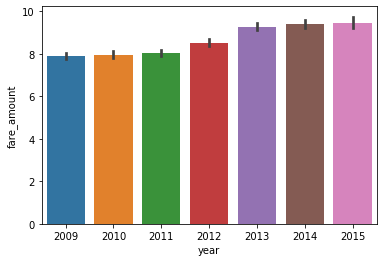

In [37]:
sns.barplot(x='year', y='fare_amount', data=cab_df)

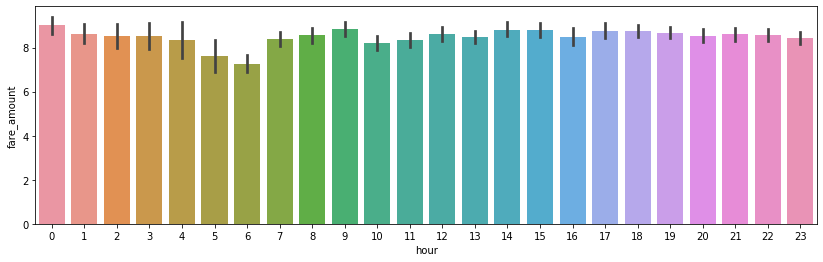

In [38]:
plt.figure(figsize=(14,4))
sns.barplot(x='hour', y='fare_amount', data=cab_df)

In [39]:
cnames=['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance',
       'year', 'hour']

In [40]:
df_corr = cab_df.loc[:,cnames]

(9.0, 0.0)

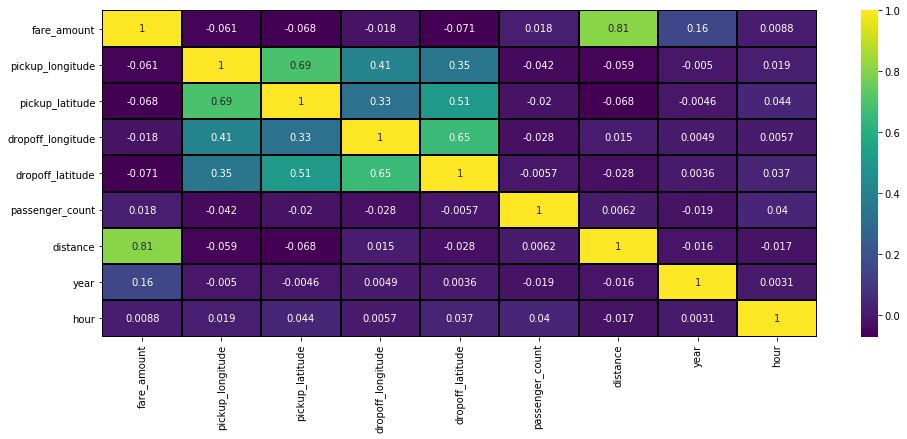

In [41]:
#Set the width and hieght of the plot
f, ax = plt.subplots(figsize=(16, 6))

#Generate correlation matrix
corr = df_corr.corr()

#Plot using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap='viridis',linewidths=1,linecolor='black',annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

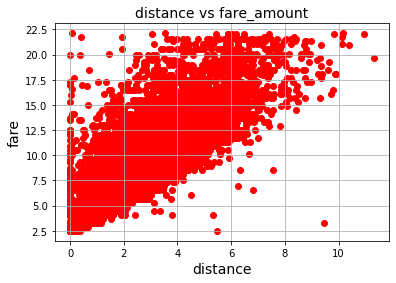

In [42]:
#Shows the distribution b/w distance and fare
plt.scatter(cab_df['distance'], cab_df['fare_amount'], color='red')

plt.title('distance vs fare_amount', fontsize=14)

plt.xlabel('distance', fontsize=14)

plt.ylabel('fare', fontsize=14)

plt.grid(True)

plt.show()

Text(0, 0.5, 'Fare')

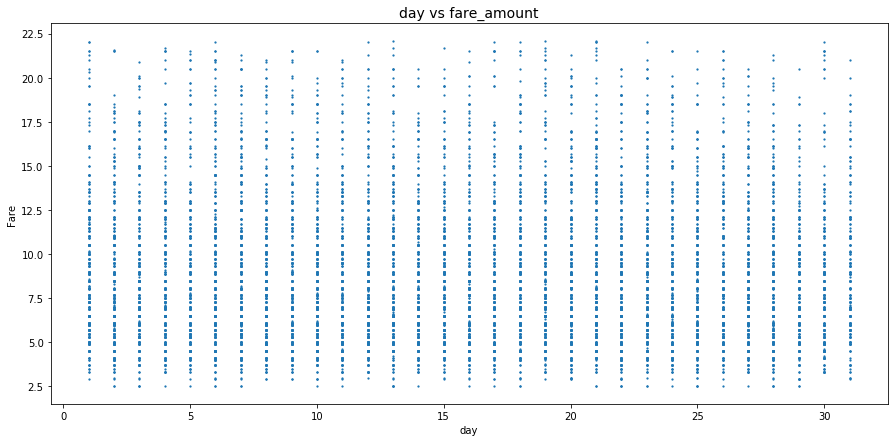

In [43]:
#shows how the different days have different fare amount
plt.figure(figsize=(15,7))
plt.scatter(x=cab_df['day'], y=cab_df['fare_amount'], s=1.5)
plt.title('day vs fare_amount', fontsize=14)
plt.xlabel('day')
plt.ylabel('Fare')

Text(0, 0.5, 'Frequency')

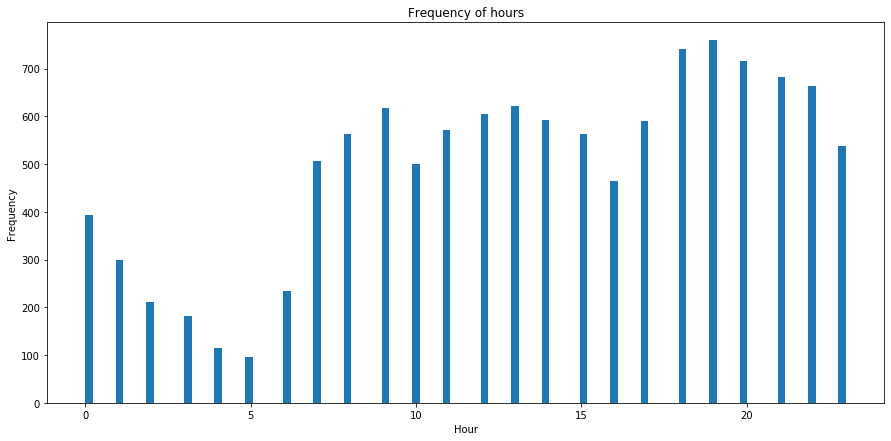

In [44]:
#shows the frequency of hours, (tells us about the most active hour)
plt.figure(figsize=(15,7))
plt.hist(cab_df['hour'], bins=100)
plt.title('Frequency of hours')
plt.xlabel('Hour')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

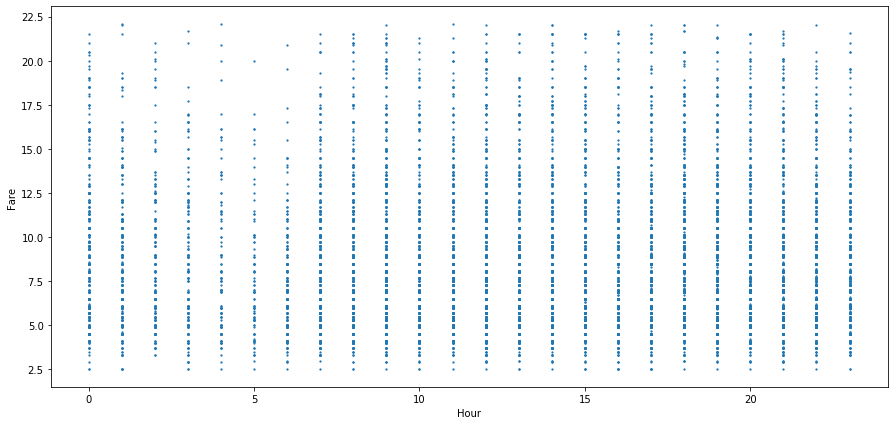

In [45]:
#Hour vs Fare_amount
plt.figure(figsize=(15,7))
plt.scatter(x=cab_df['hour'], y=cab_df['fare_amount'], s=1.5)
plt.xlabel('Hour')
plt.ylabel('Fare')

Text(0, 0.5, 'Frequency')

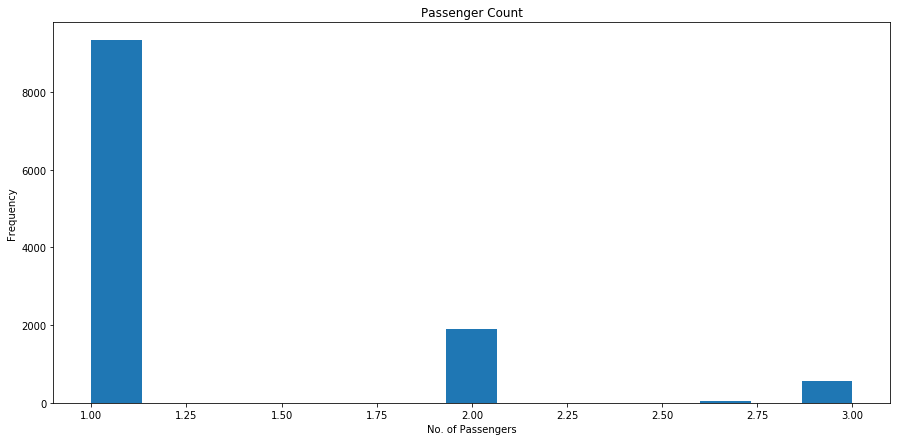

In [46]:
#shows the frequency of number of passengers
plt.figure(figsize=(15,7))
plt.hist(cab_df['passenger_count'], bins=15)
plt.title('Passenger Count')
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

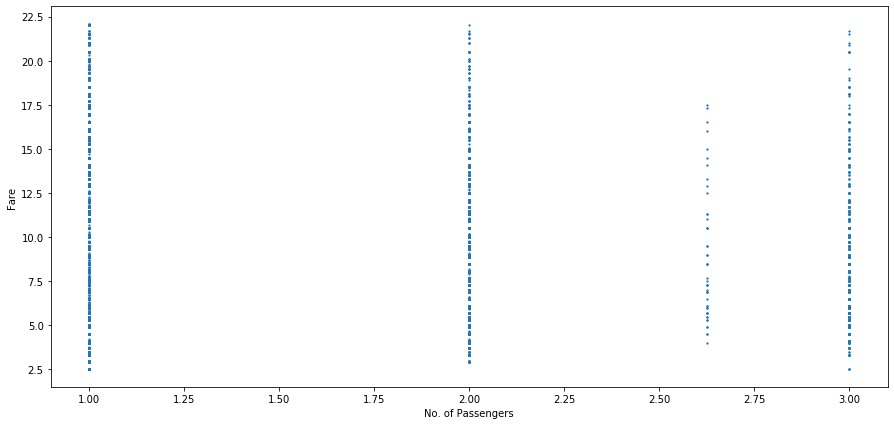

In [47]:
#Number of Passengers vs Fare_amount
plt.figure(figsize=(15,7))
plt.scatter(x=cab_df['passenger_count'], y=cab_df['fare_amount'], s=1.5)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')

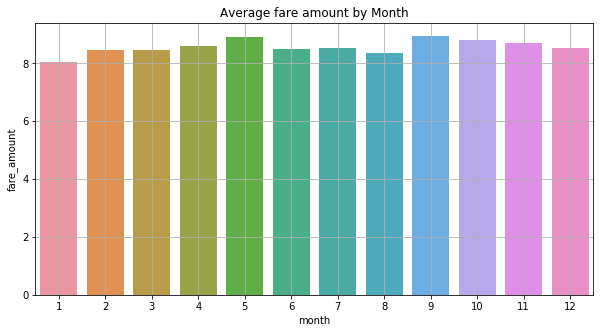

In [48]:
#Shows the average fare_amount by Month
fare_mn = cab_df.groupby("month")["fare_amount"].mean().reset_index()
plt.figure(figsize = (10,5))
sns.barplot("month","fare_amount",
            data = fare_mn,
            linewidth =1)
plt.grid(True)
plt.title("Average fare amount by Month")
plt.show()

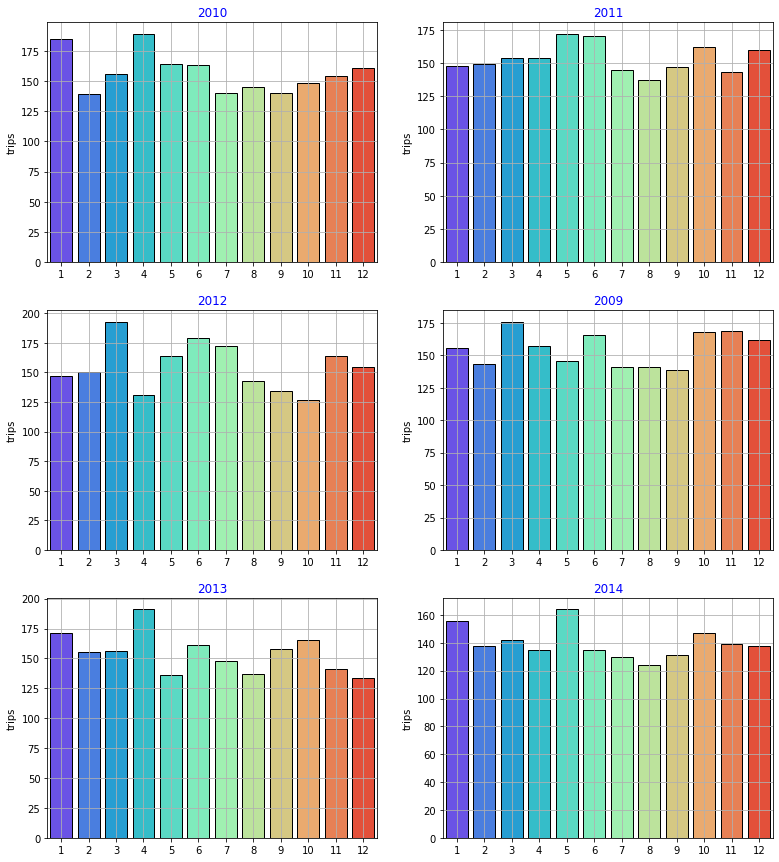

In [49]:
#shows the trends of trips every month of all years except for 2015 as it doesn't have data for all months
import itertools

yrs = [i for i in cab_df["year"].unique().tolist() if i not in [2015]]

#subset data without year 2015
complete_dat = cab_df[cab_df["year"].isin(yrs)]


plt.figure(figsize = (13,15))
for i,j in itertools.zip_longest(yrs,range(len(yrs))) :
    plt.subplot(3,2,j+1)
    trip_counts_mn = complete_dat[complete_dat["year"] == i]["month"].value_counts()
    trip_counts_mn = trip_counts_mn.reset_index()
    sns.barplot(trip_counts_mn["index"],trip_counts_mn["month"],
                palette = "rainbow",linewidth = 1,
                edgecolor = "k"*complete_dat["month"].nunique() 
               )
    plt.title(i,color = "b",fontsize = 12)
    plt.grid(True)
    plt.xlabel("")
    plt.ylabel("trips")

# Model Development

In [50]:
#cab_df_test Splitting : Simple Random Sampling as we are dealing with continuous variables
X = cab_df.iloc[:,1:].values
y = cab_df.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [51]:
#Multiple Linear Regression
import statsmodels.api as sm

model = sm.OLS(y_train,X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                          1.620e+04
Date:                Wed, 01 Jul 2020   Prob (F-statistic):                        0.00
Time:                        04:28:29   Log-Likelihood:                         -20487.
No. Observations:                9459   AIC:                                  4.100e+04
Df Residuals:                    9448   BIC:                                  4.107e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2801      1.584      0.808      0.419      -1.824       4.385
x2             1.8636      1.376      1.354      0.176      -0.834       4.561
x3             2.9563      1.589      1.861      0.063      -0.158       6.071
x4           -12.3788      1.342     -9.224      0.000     -15.009      -9.748
x5             0.1097      0.040      2.744      0.006       0.031       0.188
x6             0.3706      0.012     31.934      0.000       0.348       0.393
x7             0.0542      0.006      8.546      0.000       0.042       0.067
x8            -0.0016      0.003     -0.647      0.518      -0.007       0.003
x9            -0.0486      0.011     -4.354      0.000      -0.070      -0.027
x10            0.0131      0.003      3.804      0.000       0.006       0.020
x11            1.9694      0.014    143.275      0.000       1.942       1.996
==============================================================================
Omnibus:                     2993.125   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15225.403
Skew:                           1.440   Prob(JB):                         0.00
Kurtosis:                       8.508   Cond. No.                     2.40e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [52]:
predictions_LR = model.predict(X_test)

In [53]:
from sklearn import metrics
from math import sqrt
error = sqrt(metrics.mean_squared_error(y_test,predictions_LR)) #calculate rmse
print('RMSE value for Multiple Linear Regression is:', error)

RMSE value for Multiple Linear Regression is: 2.1318866536293912


In [54]:
from sklearn.tree import DecisionTreeRegressor

In [55]:
dtree = DecisionTreeRegressor()

In [56]:
fit_DT = dtree.fit(X_train,y_train)
fit_DT

DecisionTreeRegressor()

In [57]:
predictions_DT = dtree.predict(X_test)

In [58]:
#Calculate MAPE
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape

In [59]:
MAPE(y_test, predictions_DT)

24.0974039143322

In [60]:
error = sqrt(metrics.mean_squared_error(y_test,predictions_DT)) #calculate rmse
print('R square value for Decision Tree is: ',metrics.r2_score(y_test,predictions_DT))
print('RMSE value for Decision Tree is:', error)

R square value for Decision Tree is:  0.44929373394374084
RMSE value for Decision Tree is: 2.7629027998839852


In [61]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test) 

In [62]:
from sklearn.ensemble import RandomForestRegressor

RF_regressor = RandomForestRegressor(n_estimators=200, random_state=0)  
RF_model = RF_regressor.fit(X_train, y_train)  
predictions_RF = RF_regressor.predict(X_test)  
predictions_RF
print('R square value for Random Forest is: ',metrics.r2_score(y_test,predictions_RF))
print('RMSE value for Random Forest is :', np.sqrt(metrics.mean_squared_error(y_test, predictions_RF))) 

R square value for Random Forest is:  0.7127980576216272
RMSE value for Random Forest is : 1.995259024997251


In [63]:
MAPE(y_test, predictions_RF)

18.12401648845807

In [64]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)

X_test_scaled = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled)

In [65]:
#import required packages
from sklearn import neighbors
from math import sqrt
get_ipython()

In [66]:
KNN_model = neighbors.KNeighborsRegressor(n_neighbors = 10)
KNN_model.fit(X_train, y_train)
KNN_Predictions = KNN_model.predict(X_test)
error = sqrt(mean_squared_error(y_test,KNN_Predictions)) #calculate rmse

print('R square value for K Nearest Neighbours is: ',metrics.r2_score(y_test,KNN_Predictions))
print('RMSE value for K Nearest Neighbours is:', error)

R square value for K Nearest Neighbours is:  0.5545245493653328
RMSE value for K Nearest Neighbours is: 2.4849490316832306


In [67]:
MAPE(y_test, KNN_Predictions)

24.566069916780762

In [68]:
'''
Error metric used is Root Mean Square Error as this is a Time Series Forecasting Problem. 
It represents the sample standard deviation of the differences between predicted values and observed values (called residuals).
Lower RMSE mean better model performance.
RMSE -->
MLR : 2.13
DT : 2.78
RF : 1.99
KNN : 2.48

Best RF
'''
print('Lowest RMSE : 1.99 --> Random Forest, so using this model to predict')

Lowest RMSE : 1.99 --> Random Forest, so using this model to predict


Now that we have chosen the right model, we use it to predict fare_Amount for our test cases.
For that we first preprocess the test dataset and make it appropriate in such a way that it fits the model i.e the input variables be same as the input variables of the algorithm chosen.

# Test Data

In [69]:
test_df = pd.read_csv('test.csv')
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [70]:
#Check missing value
print(test_df.isnull().sum())

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [71]:
#Data type conversion
test_df['pickup_datetime']=pd.to_datetime(test_df['pickup_datetime'])
print(test_df.dtypes)

pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object


In [72]:
#Outlier Analysis
coutliers1=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count']
for i in coutliers1:
    q75,q25=np.percentile(test_df.loc[:,i],[75,25])
    iqr=q75-q25
    min=q25 -(1.5*iqr)
    max=q75 +(1.5*iqr)
    
    test_df=test_df.drop(test_df[test_df.loc[:,i]<min].index)
    test_df=test_df.drop(test_df[test_df.loc[:,i]>max].index)

In [73]:
#Feature Engineering
test_df['year'] = test_df.pickup_datetime.dt.year
test_df['month'] = test_df.pickup_datetime.dt.month
test_df['day'] = test_df.pickup_datetime.dt.day
test_df['weekday'] = test_df.pickup_datetime.dt.weekday
test_df['hour'] = test_df.pickup_datetime.dt.hour
del test_df['pickup_datetime']

In [74]:
test_df['distance'] = \
    haversine( test_df['pickup_latitude'], test_df['pickup_longitude'],
                test_df['dropoff_latitude'], test_df['dropoff_longitude'])

In [75]:
print(test_df.head())

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.973320        40.763805         -73.981430         40.743835   
1        -73.986862        40.719383         -73.998886         40.739201   
2        -73.982524        40.751260         -73.979654         40.746139   
3        -73.981160        40.767807         -73.990448         40.751635   
4        -73.966046        40.789775         -73.988565         40.744427   

   passenger_count  year  month  day  weekday  hour  distance  
0                1  2015      1   27        1    13  2.323259  
1                1  2015      1   27        1    13  2.425353  
2                1  2011     10    8        5    11  0.618628  
3                1  2012     12    1        5    21  1.961033  
4                1  2012     12    1        5    21  5.387301  


In [76]:
#RF_model = RandomForestRegressor(n_estimators = 200).fit(X_cab_df,y_cab_df)

In [77]:
#Feature scaling for all values to lie under 1 range and then predicting
y = sc.transform(test_df) 
predicted_fare = RF_regressor.predict(y)
predicted_fare

array([ 9.5275, 11.2125,  4.3875, ..., 17.1035,  5.0455,  7.693 ])

In [78]:
test_df['predicted_fare'] = predicted_fare

In [79]:
test_df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,weekday,hour,distance,predicted_fare
0,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13,2.323259,9.5275
1,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13,2.425353,11.2125
2,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,5,11,0.618628,4.3875
3,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,5,21,1.961033,9.1955
4,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,5,21,5.387301,14.2740


In [80]:
test_df.to_csv('test_df.csv', columns=['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude','passenger_count', 'distance','year', 'month', 'day', 'weekday', 'hour','fare_amount'], index=False)

In [81]:
import pickle
#import sklearn.externals.joblib as extjoblib
import joblib

In [82]:
joblib.dump(RF_regressor, open("predict_fare.pkl","wb"), protocol=pickle.HIGHEST_PROTOCOL)